In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('len(train) =', str(len(train)))
print('len(test) =', str(len(test)))

train.head()

len(train) = 1458644
len(test) = 625134


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [2]:
#Defining residual mean square log error function

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
#Defining holidays to be used as features

cal = calendar()
dr = pd.date_range(start='2016-01-01',end='2017-01-01')
holidays = cal.holidays(start=dr.min(), end=dr.max())

In [4]:
#Defining the haversine distance which will be used as a feature

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [5]:
#First preprocessing phase: data types and obvious features extraction

def basic_preprocess(df):
    
    df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)
    
    df.sort_values(by=['pickup_datetime'],inplace=True)

    df.pickup_datetime = pd.DatetimeIndex(df.pickup_datetime)
    
    if 'dropoff_datetime' in df:
        df.dropoff_datetime = pd.DatetimeIndex(df.dropoff_datetime)
        longitude_limit = [-74.027, -73.85]
        latitude_limit = [40.67, 40.85]
        df = df[(df.pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
        df = df[(df.dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
        df = df[(df.pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
        df = df[(df.dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
        df['kms_per_minute'] = df.distance/(df.trip_duration/60)
        df['log_trip_duration'] = np.log(df['trip_duration'].values + 1)
        
    df['date'] = pd.to_datetime(df.pickup_datetime.apply(lambda x: x.date()))
    
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df['dow'] = df.pickup_datetime.apply(lambda x: x.day % 7)
    df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    df['minute'] = df.pickup_datetime.apply(lambda x: x.minute)
    
    df['is_weekend']= df.pickup_datetime.apply(lambda x: int(x.day//5==1))
    df['is_holiday'] = df.pickup_datetime.apply(lambda x: x.date() in holidays)
    df['next_is_holiday'] = np.roll(df.is_holiday.values,-1)

    df['coefficient_director'] = (df.dropoff_longitude - df.pickup_longitude).divide(
                                df.dropoff_latitude - df.pickup_latitude)
    df.loc[df.coefficient_director.isnull(),'coefficient_director'] = 0
    df['cosin'] = (df.dropoff_latitude.multiply(df.pickup_latitude) 
                   + df.dropoff_longitude.multiply(df.pickup_longitude))

    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1, 0: 0, 1: 1}).astype(int)
    
    return df

train = basic_preprocess(train)
test = basic_preprocess(test)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,date,month,dow,hour,minute,is_weekend,is_holiday,next_is_holiday,coefficient_director,cosin
96469,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,0,...,2016-01-01,1,1,0,0,0,True,True,0.390056,7132.653231
223872,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,0,...,2016-01-01,1,1,0,0,0,True,True,-0.911428,7130.914076
713067,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,0,...,2016-01-01,1,1,0,1,0,True,True,1.259719,7134.847328
652463,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,0,...,2016-01-01,1,1,0,1,0,True,True,9.123077,7134.679569
722901,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,0,...,2016-01-01,1,1,0,1,0,True,True,1.144997,7133.676795


Let's visualize pickup and dropoff points to get a better idea of main traffic areas.


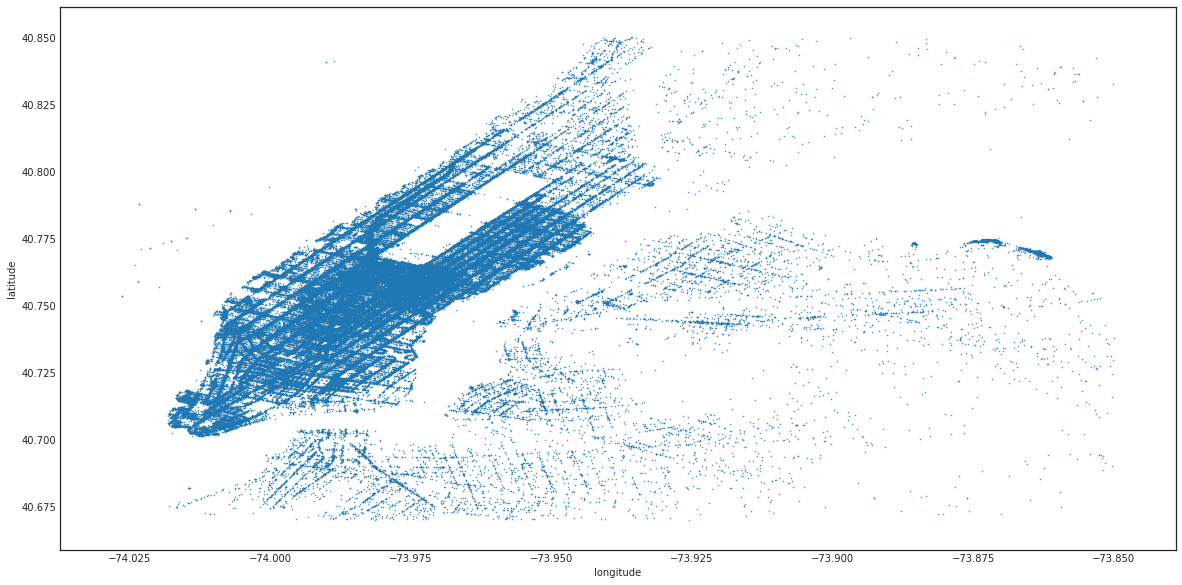

In [7]:
#Simple data viz of pickups and dropoffs

print("""Let's visualize pickup and dropoff points to get a better idea of main traffic areas.""")

plt.figure(figsize=(20,10))
longitude = list(train.pickup_longitude) + list(train.dropoff_longitude)
latitude = list(train.pickup_latitude) + list(train.dropoff_latitude)

data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})

sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

It is also important to look at the variations of taxi traffic by Month, DOW, and Hour, 
to have an idea of the importance of these features.


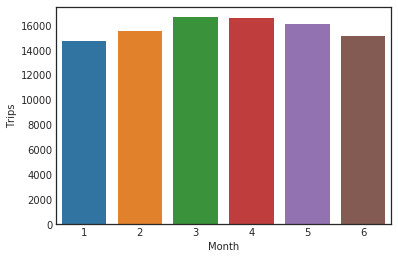

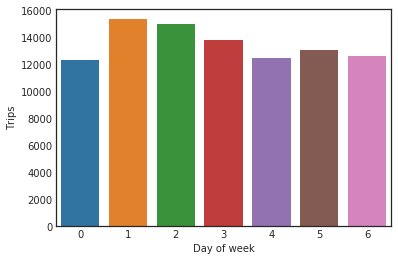

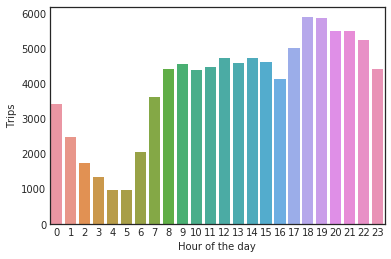

In [8]:
#Quick viz of seasonality effects

print("""It is also important to look at the variations of taxi traffic by Month, DOW, and Hour, 
to have an idea of the importance of these features.""")

ax = sns.countplot(train.month)
ax.set(xlabel='Month', ylabel='Trips')
plt.show()

ax1 = sns.countplot(train.dow)
ax1.set(xlabel='Day of week', ylabel='Trips')
plt.show()

ax2 = sns.countplot(train.hour)
ax2.set(xlabel='Hour of the day', ylabel='Trips')
plt.show()

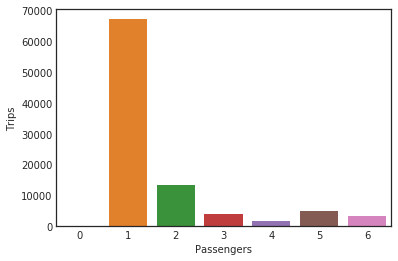

In [9]:
#Quick viz of passenger counts distribution

ax = sns.countplot(train.passenger_count)
ax.set(xlabel='Passengers', ylabel='Trips')
plt.show()

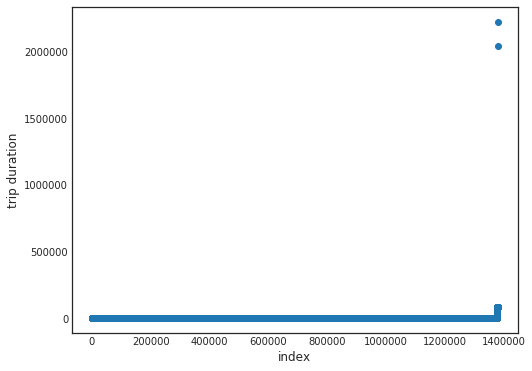

In [33]:
#Checking for duration outliers

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

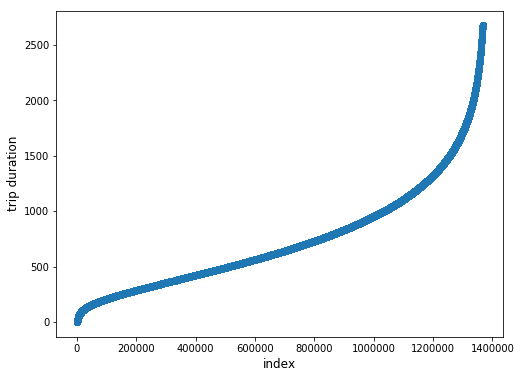

In [6]:
#Cleaning duration outliers

q = train.trip_duration.quantile(0.99)
train = train[train.trip_duration < q]

#Showing new chart
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

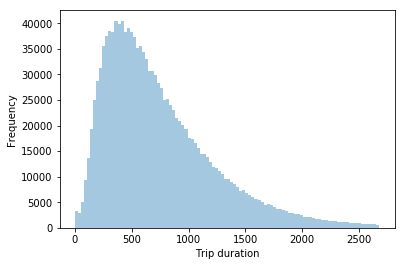

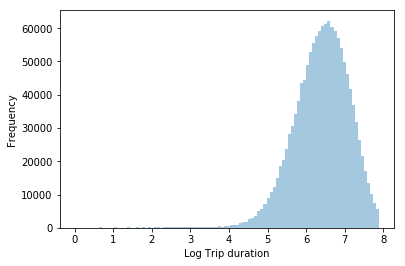

In [7]:
#Quick viz of durations distribution

ax = sns.distplot(train.trip_duration, bins=100, kde=False)
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
plt.show()

train.log_trip_duration = np.log(train.trip_duration)

ax = sns.distplot(train.log_trip_duration, bins=100, kde=False)
plt.xlabel('Log Trip duration')
plt.ylabel('Frequency')
plt.show()

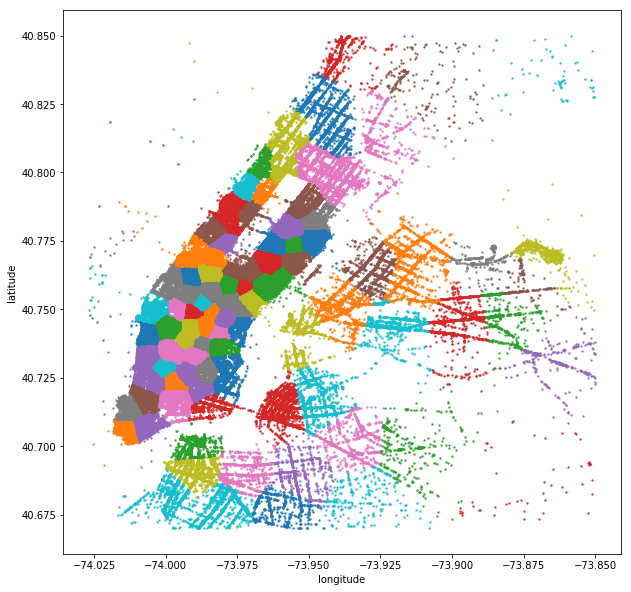

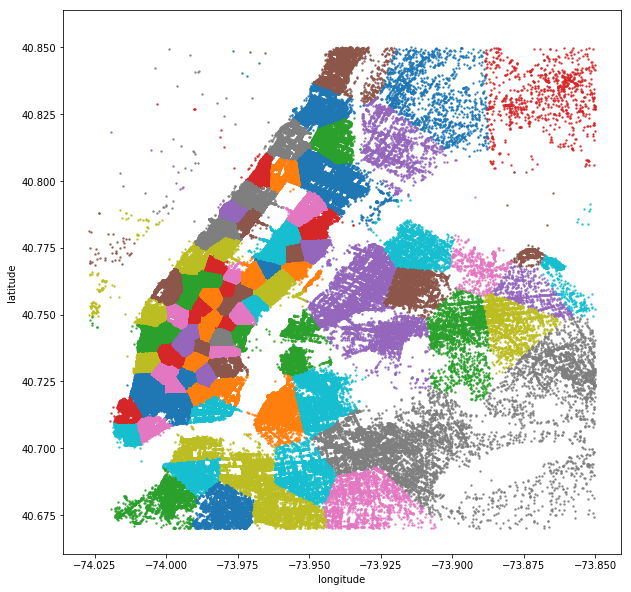

In [8]:
#Kmeans Clustering of pickup longitude/latitude using MiniBatchKMeans with visualization:

coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_label'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_label'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_label'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_label'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#Clusters viz on the training set

plt.figure(figsize=(10, 10))
for label in train.pickup_label.unique():
    label_data = pd.DataFrame({'latitude': train.pickup_latitude[train.pickup_label == label], 
                               'longitude': train.pickup_longitude[train.pickup_label == label]})
    sns.regplot(x="longitude", y="latitude", data=label_data, scatter=True, fit_reg=False, scatter_kws={"s": 2})
    
plt.figure(figsize=(10, 10))
for label in train.dropoff_label.unique():
    label_data = pd.DataFrame({'latitude': train.dropoff_latitude[train.dropoff_label == label], 
                               'longitude': train.dropoff_longitude[train.dropoff_label == label]})
    sns.regplot(x="longitude", y="latitude", data=label_data, scatter=True, fit_reg=False, scatter_kws={"s": 2})

In [9]:
print("""We will now calculate the median and average trip duration of most similar trips.""")

train['direction_cluster'] = train['pickup_label'].astype(str) + '-' + train['dropoff_label'].astype(str)
test['direction_cluster'] = test['pickup_label'].astype(str) + '-' + test['dropoff_label'].astype(str)

count_check = train.groupby(['direction_cluster']).size().reset_index(name='count')

mean_calc = train.groupby(['direction_cluster'])['trip_duration'].mean().reset_index()
mean = mean_calc.trip_duration.mean()
mean_calc = mean_calc[['direction_cluster', 'trip_duration']].to_dict()
cluster_mean = {v: mean_calc['trip_duration'][k] for k, v in mean_calc['direction_cluster'].items()}

med_calc = train.groupby(['direction_cluster'])['trip_duration'].median().reset_index()
med = med_calc.trip_duration.median()
med_calc = med_calc[['direction_cluster', 'trip_duration']].to_dict()
cluster_med = {v: med_calc['trip_duration'][k] for k, v in med_calc['direction_cluster'].items()}

train['mean_similar'] = train.direction_cluster.apply(lambda x: cluster_mean.get(x, mean))
train['med_similar'] = train.direction_cluster.apply(lambda x: cluster_med.get(x, med))

test['mean_similar'] = test.direction_cluster.apply(lambda x: cluster_mean.get(x, mean))
test['med_similar'] = test.direction_cluster.apply(lambda x: cluster_med.get(x, med))

train.head()

We will now calculate the median and average trip duration of most similar trips.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,is_weekend,is_holiday,next_is_holiday,coefficient_director,cosin,pickup_label,dropoff_label,direction_cluster,mean_similar,med_similar
96469,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,0,...,0,True,True,0.390056,7132.653231,97,12,97-12,1505.000000,1471.0
223872,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,0,...,0,True,True,-0.911428,7130.914076,96,58,96-58,1420.298701,1360.0
713067,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,0,...,0,True,True,1.259719,7134.847328,17,82,17-82,693.267974,679.0
652463,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,0,...,0,True,True,9.123077,7134.679569,96,2,96-2,387.682927,351.0
722901,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,0,...,0,True,True,1.144997,7133.676795,42,64,42-64,785.391593,737.0


Now let's take a look at the time serie to detect eventual exceptional days.


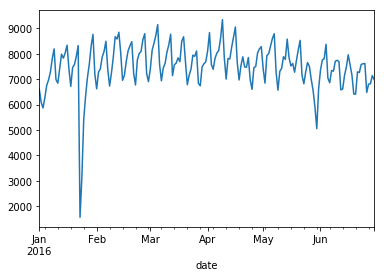


We can spot two days with very low activity, which correspond to a snowstorm:
https://en.wikipedia.org/wiki/January_2016_United_States_blizzard.


In [10]:
print("""Now let's take a look at the time serie to detect eventual exceptional days.""")

ts = train.groupby('date').size().reset_index(name='count')

ts = pd.Series(ts['count'].values, index=ts['date'])
ts.plot()
plt.show()

print("""
We can spot two days with very low activity, which correspond to a snowstorm:
https://en.wikipedia.org/wiki/January_2016_United_States_blizzard.""")

In [10]:
print("""Now let's add weather data as it seems to have a potentially strong impact on traffic conditions.""")

weather = pd.read_csv('weather_data_nyc_2016.csv')

weather[['precipitation', 'snow fall', 'snow depth']] = weather[['precipitation', 'snow fall', 'snow depth']].applymap(lambda x: 0.01 if x == 'T' else float(x))

weather['date'] = pd.to_datetime(weather.date)

weather = weather[['date', 'average temperature', 'precipitation', 'snow fall', 'snow depth']]

train = pd.merge(train, weather, how='left', on='date')
test = pd.merge(test, weather, how='left', on='date')

train.head()

Now let's add weather data as it seems to have a potentially strong impact on traffic conditions.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,cosin,pickup_label,dropoff_label,direction_cluster,mean_similar,med_similar,average temperature,precipitation,snow fall,snow depth
0,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,0,...,7132.653231,97,12,97-12,1505.000000,1471.0,38.0,0.0,0.0,0.0
1,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,0,...,7130.914076,96,58,96-58,1420.298701,1360.0,38.0,0.0,0.0,0.0
2,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,0,...,7134.847328,17,82,17-82,693.267974,679.0,38.0,0.0,0.0,0.0
3,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,0,...,7134.679569,96,2,96-2,387.682927,351.0,38.0,0.0,0.0,0.0
4,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,0,...,7133.676795,42,64,42-64,785.391593,737.0,38.0,0.0,0.0,0.0


In [11]:
print("""Let's calculate the average speed by hour of the day and add this to our sets.""")

mean_speed = train.groupby(['hour'])['kms_per_minute'].mean().reset_index(name='mean_speed')
med_speed = train.groupby(['hour'])['kms_per_minute'].median().reset_index(name='med_speed')

train = pd.merge(train, mean_speed, how='left', on=['hour'])
train = pd.merge(train, med_speed, how='left', on=['hour'])
test = pd.merge(test, mean_speed, how='left', on=['hour'])
test = pd.merge(test, med_speed, how='left', on=['hour',])

train.drop(['kms_per_minute'], axis=1, inplace=True)

train.head()

Let's calculate the average speed by hour of the day and add this to our sets.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_label,direction_cluster,mean_similar,med_similar,average temperature,precipitation,snow fall,snow depth,mean_speed,med_speed
0,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,0,...,12,97-12,1505.000000,1471.0,38.0,0.0,0.0,0.0,0.277421,0.258369
1,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,0,...,58,96-58,1420.298701,1360.0,38.0,0.0,0.0,0.0,0.277421,0.258369
2,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,0,...,82,17-82,693.267974,679.0,38.0,0.0,0.0,0.0,0.277421,0.258369
3,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,0,...,2,96-2,387.682927,351.0,38.0,0.0,0.0,0.0,0.277421,0.258369
4,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,0,...,64,42-64,785.391593,737.0,38.0,0.0,0.0,0.0,0.277421,0.258369


It would be interesting to see if we can idenfity a relationship between the amount of traffic and
the average_speed and trip_duration.


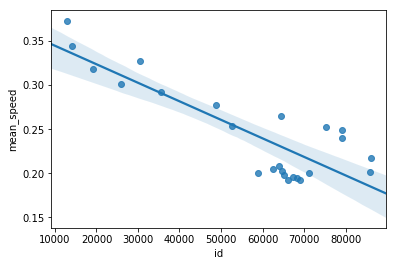

In [12]:
print("""It would be interesting to see if we can idenfity a relationship between the amount of traffic and
the average_speed and trip_duration.""")

traffic = train.groupby('hour')['id'].nunique().reset_index()
duration = train.groupby('hour')['trip_duration'].mean().reset_index()
speed = train.groupby('hour')['mean_speed'].mean().reset_index()

traffic_speed = pd.merge(traffic, speed, how='left', on='hour')
traffic_duration = pd.merge(traffic, duration, how='left', on='hour')

ax = sns.regplot(x="id", y="mean_speed", data=traffic_speed)

In [13]:
print("""As the relationship seems strong and linear, what we could do would be to add as a new feature
a traffic indicator giving an the current amount of traffic.""")

traffic = train.groupby(['date', 'hour'])['id'].nunique().reset_index(name='total_traffic')

#train = train.drop('trip_duration_y', axis=1, inplace=True)

train = pd.merge(train, traffic, how='left', on=['date', 'hour'])
test = pd.merge(test, traffic, how='left', on=['date', 'hour'])

print(train.columns)
print(test.columns)
train.head()

As the relationship seems strong and linear, what we could do would be to add as a new feature
a traffic indicator giving an the current amount of traffic.
Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'log_trip_duration', 'date', 'month',
       'dow', 'hour', 'minute', 'is_weekend', 'is_holiday', 'next_is_holiday',
       'coefficient_director', 'cosin', 'pickup_label', 'dropoff_label',
       'direction_cluster', 'mean_similar', 'med_similar',
       'average temperature', 'precipitation', 'snow fall', 'snow depth',
       'mean_speed', 'med_speed', 'total_traffic'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'distance', 'date', 'month',
  

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,direction_cluster,mean_similar,med_similar,average temperature,precipitation,snow fall,snow depth,mean_speed,med_speed,total_traffic
0,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,0,...,97-12,1505.000000,1471.0,38.0,0.0,0.0,0.0,0.277421,0.258369,519
1,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,0,...,96-58,1420.298701,1360.0,38.0,0.0,0.0,0.0,0.277421,0.258369,519
2,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,0,...,17-82,693.267974,679.0,38.0,0.0,0.0,0.0,0.277421,0.258369,519
3,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,0,...,96-2,387.682927,351.0,38.0,0.0,0.0,0.0,0.277421,0.258369,519
4,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,0,...,42-64,785.391593,737.0,38.0,0.0,0.0,0.0,0.277421,0.258369,519


In [23]:
print("""Let's do a quick cleanup before building our model.""")

cat_vars = ['vendor_id', 'store_and_fwd_flag', 'month', 'dow', 'hour', 
            'is_weekend', 'is_holiday', 'next_is_holiday']

#Replacing NaNs with mean and median

mean = train.groupby('direction_cluster')['mean_speed'].transform('mean')
med = train.groupby('direction_cluster')['med_speed'].transform('median')

test.mean_speed = test.mean_speed.fillna(mean)
test.med_speed = test.med_speed.fillna(med)

#Dummy features

train_dummies = pd.get_dummies(data=train, columns=cat_vars)
test_dummies = pd.get_dummies(data=test, columns=cat_vars)

#Preparing data for training and submission

test_id = test_dummies['id']

train_drop = ['id', 'pickup_longitude','pickup_latitude', 
             'dropoff_longitude','dropoff_latitude', 'dropoff_datetime', 
             'trip_duration', 'pickup_datetime', 'date', 'direction_cluster']

test_drop = ['id', 'pickup_longitude','pickup_latitude', 
             'dropoff_longitude','dropoff_latitude',
            'pickup_datetime', 'date', 'direction_cluster']

train_dummies.drop(train_drop, axis=1, inplace=True)
test_dummies.drop(test_drop, axis=1, inplace=True)

missing_columns = [c for c in train_dummies.columns if c not in test_dummies.columns]

print(missing_columns)

Let's do a quick cleanup before building our model.
['log_trip_duration']


In [24]:
from sklearn.cross_validation import train_test_split

train_split, test_split = train_test_split(train_dummies, test_size=0.2)

In [25]:
X_train = train_split.drop(['log_trip_duration'], axis=1)
Y_train = train_split["log_trip_duration"]
X_test = test_split.drop(['log_trip_duration'], axis=1)
Y_test = test_split["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

[0]	train-rmse:2.98693	valid-rmse:2.98646
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 1 rounds.
[1]	train-rmse:1.53268	valid-rmse:1.53252
[2]	train-rmse:0.839049	valid-rmse:0.839205
[3]	train-rmse:0.536231	valid-rmse:0.536911
[4]	train-rmse:0.426379	valid-rmse:0.427556
[5]	train-rmse:0.392586	valid-rmse:0.3941
[6]	train-rmse:0.381646	valid-rmse:0.383235
[7]	train-rmse:0.377134	valid-rmse:0.379157
[8]	train-rmse:0.373651	valid-rmse:0.376004
[9]	train-rmse:0.37171	valid-rmse:0.374499
[10]	train-rmse:0.370064	valid-rmse:0.373319
[11]	train-rmse:0.368918	valid-rmse:0.372517
[12]	train-rmse:0.367763	valid-rmse:0.371703
[13]	train-rmse:0.366443	valid-rmse:0.370401
[14]	train-rmse:0.365538	valid-rmse:0.3696
[15]	train-rmse:0.364681	valid-rmse:0.368961
[16]	train-rmse:0.364008	valid-rmse:0.368557
[17]	train-rmse:0.363502	valid-rmse:0.368213
[18]	train-rmse:0.363028	valid-rmse:0.367914
[19]	train-rmse:0.36

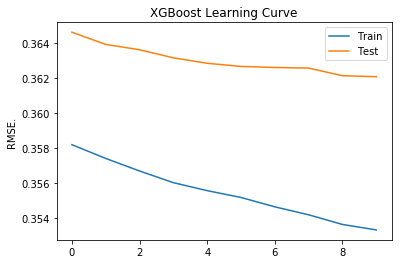

In [26]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(test_dummies)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {
    'min_child_weight': 1, 
    'eta': 0.5, 
    'colsample_bytree': 0.9, 
    'max_depth': 6,
    'subsample': 0.9, 
    'lambda': 1., 
    'nthread': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse', 
    'objective': 'reg:linear'
}

progress = dict()

model = xgb.train(xgb_pars, dtrain, 35, watchlist, early_stopping_rounds=1,
      maximize=False, verbose_eval=1, evals_result=progress)

print('Modeling RMSLE %.5f' % model.best_score)

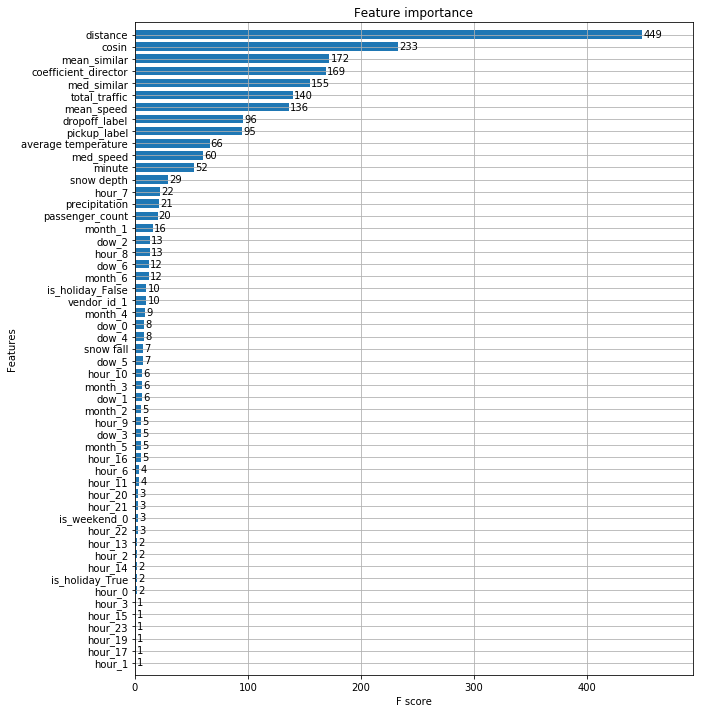

In [33]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(model, height=0.7, ax=ax)

In [31]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

submission = pd.concat([test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

In [32]:
print(len(submission))

625134
